In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from sklearn.preprocessing import scale
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm_notebook as tqdm
from IPython.utils import io

from Peony_box.src.peony_box_model import PeonyBoxModel
from Peony_box.src.acquisition_functions.functions import batch_bald, entropy_sampling, hac_sampling, power_bald
from Peony_box.src.utils import k_fold_corss_validation, auc_metrics
from Peony_visualization.src.peony_visualization import visualize_two_auc_evolutions

/Users/mark/anaconda3/envs/peony_project/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def to_torch_tensors(data):
    return [[torch.Tensor(v)] for v in data]

In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.92)

## Initialize model and train

In [11]:
peony_model = PeonyBoxModel(None, acquisition_function=power_bald, active_learning_step=10)
peony_model.bayesian_dropout_nn.epsilon_greedy_coef = 1

In [12]:
peony_model.bayesian_dropout_nn.fit(to_torch_tensors(X_train), list(Y_train), False)

[['starting loss is 0.6641519069671631',
  'fitted loss (samples mean) is 0.3458337187767029']]

## Simulate predictions

In [13]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = to_torch_tensors(grid.reshape(2, -1).transpose())

In [14]:
first_iter = peony_model.bayesian_dropout_nn.predict(grid_2d, False)

In [15]:
def plot_uncertainty_gird(prediction, new_indices = None):
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    fig, ax = plt.subplots(figsize=(16, 9))
    contour = ax.contourf(grid[1], grid[0], prediction.reshape(100, 100).transpose(), cmap=cmap)
    ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
    ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
    if new_indices is not None:
        ax.scatter(X_test[new_indices,0],X_test[new_indices,1], color='aqua', marker="*", linewidths = 4)
    cbar = plt.colorbar(contour, ax=ax)
    _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
    cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [16]:
indices  = peony_model.bayesian_dropout_nn.get_learning_samples(to_torch_tensors(X_test), False)
instances_to_add = [to_torch_tensors(X_test)[i] for i in indices] 
labels_to_add = [list(Y_test)[i] for i in indices]

peony_model.bayesian_dropout_nn.add_new_learning_samples(instances_to_add, labels_to_add, False)
second_iter = peony_model.bayesian_dropout_nn.predict(grid_2d, False)

/Users/mark/Documents/Git/Peony/Peony_project/Peony_box/src/acquisition_functions/functions.py:161: RuntimeWarning: invalid value encountered in log
  bald(labels),


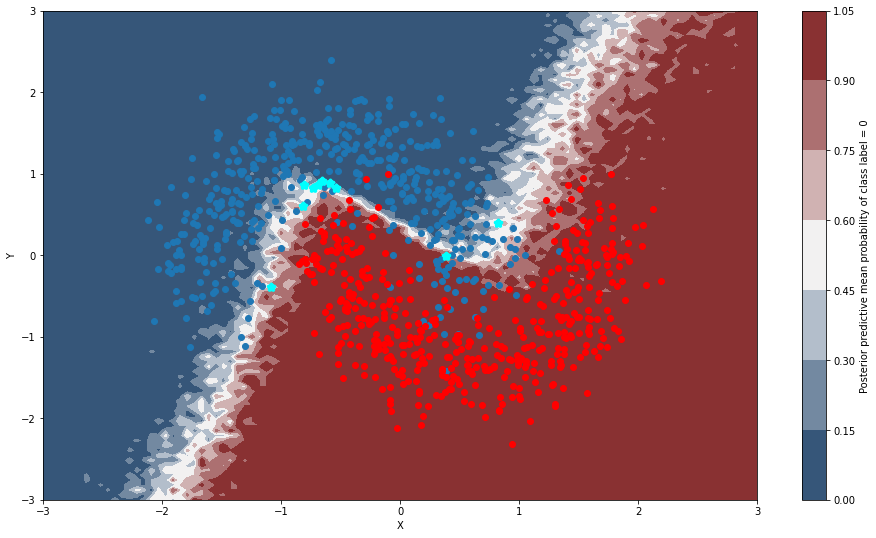

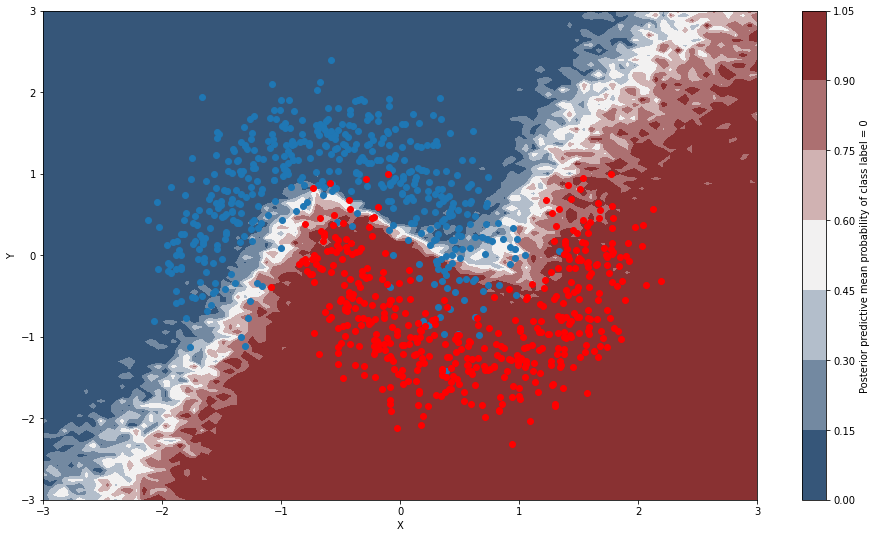

In [10]:
plot_uncertainty_gird(first_iter,indices)
plot_uncertainty_gird(second_iter)

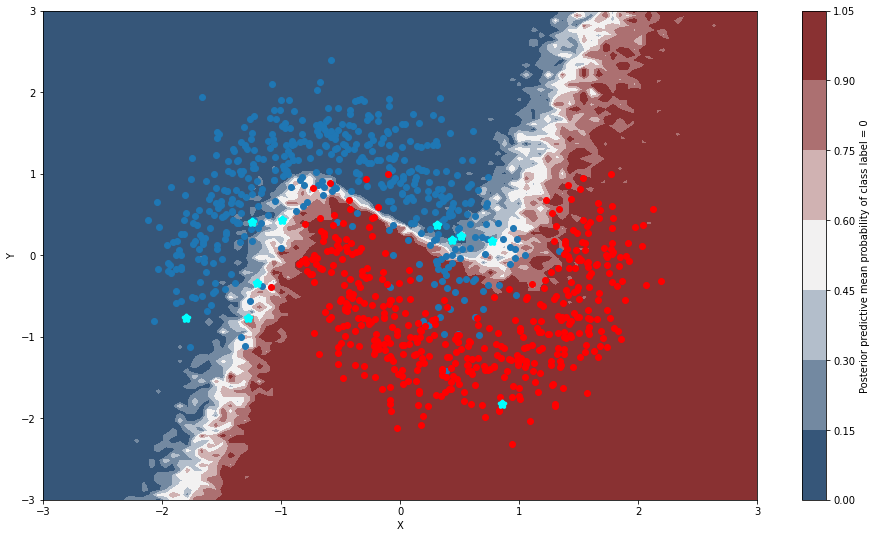

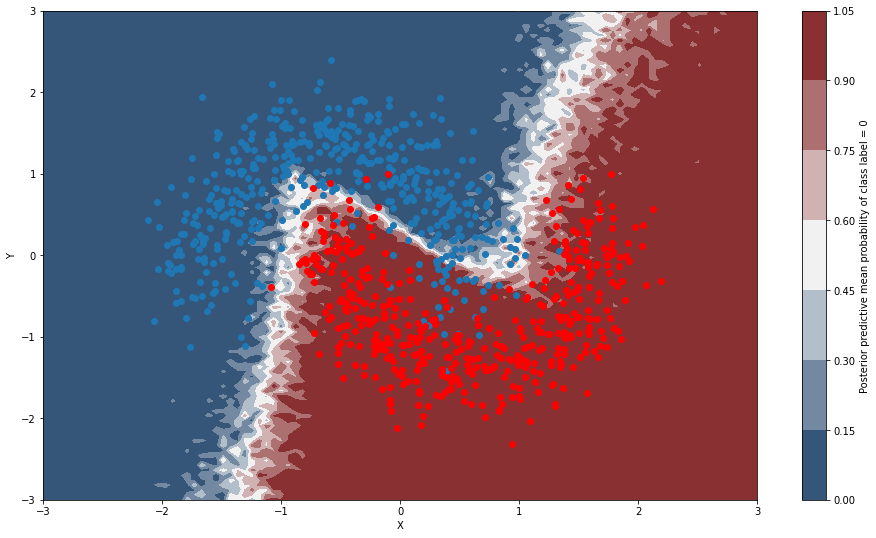

In [17]:
plot_uncertainty_gird(first_iter,indices)
plot_uncertainty_gird(second_iter)